In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd
import joblib

In [2]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score, roc_curve
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import multilabel_confusion_matrix

from sklearn.preprocessing import label_binarize

2024-05-28 16:19:35.990421: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-28 16:19:36.159168: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-05-28 16:19:36.159203: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-05-28 16:19:36.198091: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-28 16:19:37.063121: W tensorflow/stream_executor/platform/de

In [3]:
def re_dataset(dataset):
    #print(dataset.head())
    tcp_flag = dataset['TCP Flag'].values
    tcp_U = []
    tcp_A = []
    tcp_P = []
    tcp_R = []
    tcp_S = []
    tcp_F = []

    #UAPRSF
    for flag in tcp_flag:
        ll = 0
        for tcp in [tcp_U,tcp_A,tcp_P,tcp_R,tcp_S,tcp_F]:
            #print(flag[ll])
            if flag[ll] == '-':
                tcp.append(0)
            else:
                tcp.append(1)
            ll += 1
    dataset.insert(7, column="tcp_U", value=tcp_U)
    dataset.insert(8, column="tcp_A", value=tcp_A)
    dataset.insert(9, column="tcp_P", value=tcp_P)
    dataset.insert(10, column="tcp_R", value=tcp_R)
    dataset.insert(11, column="tcp_S", value=tcp_S)
    dataset.insert(12, column="tcp_F", value=tcp_F)
    dataset.drop(columns=['TCP Flag'], inplace=True, axis=1)
    return dataset

In [4]:
def train_data_func(filename):
    # First, we get the data
    dataset = pd.read_csv(filename, index_col='資料時間', parse_dates=['資料時間'])
    dataset = dataset.drop(['來源名稱解析','來源區域','來源Port解析','目的名稱解析','目的區域','目的Port解析','流入介面','流出介面','設備'], axis=1)
    dataset = re_dataset(dataset)
    print("hacker 0:", len(dataset[dataset["hacker"]==0]), "hacker 1:", len(dataset[dataset["hacker"]==1]), "hacker 2:", len(dataset[dataset["hacker"]==2]))
    text_set = dataset[['來源IP','Protocol','目的IP']]
    num_set = dataset[['Session','Packets','Bytes','tcp_U','tcp_A','tcp_P','tcp_R','tcp_S','tcp_F']]#'來源Port','目的Port',,'dstip_count','dstport_count'

    xx_text = text_set.iloc[:,:].to_numpy()
    xx_num = num_set.iloc[:,:].to_numpy()
    yy = dataset.iloc[:,-1].to_numpy()

    # 將數字特徵進行標準化
    #scaler = StandardScaler()
    scaler = MinMaxScaler()
    numeric_data_scaled = scaler.fit_transform(xx_num)
    # 保存標準化參數
    joblib.dump(scaler, 'scaler.pkl')

    # 將標籤轉換為 one-hot 編碼
    yy = to_categorical(yy, 3)

    # 將文字特徵進行 One-Hot 編碼
    encoder = OneHotEncoder( categories='auto')#sparse_output=False,
    text_data_encoded = encoder.fit_transform(xx_text.reshape(-1, 1))#
    print(numeric_data_scaled.shape, text_data_encoded.shape)

    X = np.array(list(zip(numeric_data_scaled, text_data_encoded)), dtype="object")
    # 分割數據集為訓練集和測試集
    X_train, X_test, y_train, y_test = train_test_split(
        X, yy, test_size=0.2, random_state=49
    )
    print('訓練集:',X_train.shape, '測試集:', X_test.shape)
    # 分割文字與數字資料集
    X_train_numeric, X_train_text = X_train[:, 0], X_train[:, 1]
    X_test_numeric, X_test_text = X_test[:, 0], X_test[:, 1]

    X_train_numeric = np.array([np.array(val) for val in X_train_numeric])
    X_train_text = np.array([np.array(val) for val in X_train_text])
    y_train = np.array([np.array(val) for val in y_train])
    X_test_numeric = np.array([np.array(val) for val in X_test_numeric])
    X_test_text = np.array([np.array(val) for val in X_test_text])
    y_test = np.array([np.array(val) for val in y_test])
    print(X_train_numeric.shape, X_train_text.shape, y_train.shape, X_test_numeric.shape, X_test_text.shape, y_test.shape)
    
  
    
    
    # 創建隨機森林分類器
    rf = RandomForestClassifier(n_estimators=100, random_state=64)  # 使用100棵樹
    # 將數字特徵和文字特徵分別傳遞給模型進行訓練
    rf.fit(X_train_numeric, y_train)
    # 進行預測
    y_pred = rf.predict(X_test_numeric)
    #print(y_test.shape)  # 查看形狀
    #print(y_test[:5])    # 查看前幾個數據點來理解數據的結構
    #print(y_pred.shape)  # 查看形狀
    #print(y_pred[:5])    # 查看前幾個數據點來理解數據的結構
    
    # 計算準確率
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)
    
    f1 = f1_score(y_test, y_pred, average='weighted')  # 'weighted' 可以根據需要選擇 'micro', 'macro', 'binary' 等
    f1_micro = f1_score(y_test, y_pred, average='micro')
    f1_macro = f1_score(y_test, y_pred, average='macro')
    f1_weighted = f1_score(y_test, y_pred, average='weighted')

    print(f"Micro F1-Score: {f1_micro}")
    print(f"Macro F1-Score: {f1_macro}")
    print(f"Weighted F1-Score: {f1_weighted}")
    
    auc = roc_auc_score(y_test, y_pred, average='macro', multi_class='ovr')
    print(f"AUC: {auc}")
    
    importances = rf.feature_importances_
    indices = np.argsort(importances)[::-1]

    # 繪圖
    train_accuracy = []
    test_accuracy = []
    estimator_range = range(1, 101, 5)

    for n_estimators in estimator_range:
        rf = RandomForestClassifier(n_estimators=n_estimators)#, random_state=42
        rf.fit(X_train_numeric, y_train)
        train_accuracy.append(rf.score(X_train_numeric, y_train))
        test_accuracy.append(rf.score(X_test_numeric, y_test))

    # 繪圖
    plt.figure()
    plt.plot(estimator_range, train_accuracy, label="Train Accuracy")
    plt.plot(estimator_range, test_accuracy, label="Test Accuracy")
    plt.xlabel("Number of Trees")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

    return rf

In [5]:
def vail_data(rf, filename):
    dataset_test = pd.read_csv(filename, index_col='資料時間', parse_dates=['資料時間'])
    dataset_test = dataset_test.drop(['來源名稱解析','來源區域','來源Port解析','目的名稱解析','目的區域','目的Port解析','流入介面','流出介面','設備'], axis=1)
    dataset_test = re_dataset(dataset_test)
    print("hacker 0:", len(dataset_test[dataset_test["hacker"]==0]), ", hacker 1:", len(dataset_test[dataset_test["hacker"]==1]), ", hacker 2:", len(dataset_test[dataset_test["hacker"]==2]))
    text_set = dataset_test[['來源IP','Protocol','目的IP']]
    num_set = dataset_test[['Session','Packets','Bytes','tcp_U','tcp_A','tcp_P','tcp_R','tcp_S','tcp_F']]#'來源Port','目的Port',,'dstip_count','dstport_count'
    test_xx_text = text_set.iloc[:,:].to_numpy()
    test_xx_num = num_set.iloc[:,:].to_numpy()
    test_yy = dataset_test.iloc[:,-1].to_numpy()
    test_xx_text.shape, test_xx_num.shape, test_yy.shape
    # 將數字特徵進行標準化
    #scaler = StandardScaler()
    # 載入標準化參數
    scaler = joblib.load('scaler.pkl')
    test_numeric_data_scaled = scaler.fit_transform(test_xx_num)
    
    # 將標籤轉換為 one-hot 編碼
    #test_yy = to_categorical(test_yy, 3)
    
    x_new_test_numeric = np.array([np.array(val) for val in test_numeric_data_scaled])
    #x_new_test_text = np.array([np.array(val) for val in test_text_data_encoded])
    y_new_test = np.array([np.array(val) for val in test_yy])
    #print(y_new_test.shape)  # 查看形狀
    #print(y_new_test[:5])    # 查看前幾個數據點來理解數據的結構
    
    # 進行預測
    y_pred = rf.predict(x_new_test_numeric)
    class_predictions = np.argmax(y_pred, axis=1)
    #print(class_predictions.shape)  # 查看形狀
    #print(class_predictions[:5])    # 查看前幾個數據點來理解數據的結構

    # 計算準確率
    accuracy = accuracy_score(y_new_test, class_predictions)
    print("Accuracy:", accuracy)
    
    y_test_bin = label_binarize(y_new_test, classes=[0, 1, 2])
    #f1 = f1_score(y_new_test, y_pred, average='weighted')  # 'weighted' 可以根據需要選擇 'micro', 'macro', 'binary' 等
    f1_micro = f1_score(y_test_bin, y_pred, average='micro')
    f1_macro = f1_score(y_test_bin, y_pred, average='macro')
    f1_weighted = f1_score(y_test_bin, y_pred, average='weighted')

    print(f"Micro F1-Score: {f1_micro}")
    print(f"Macro F1-Score: {f1_macro}")
    print(f"Weighted F1-Score: {f1_weighted}")
    
    auc = roc_auc_score(y_test_bin, y_pred, average='macro', multi_class='ovr')
    print(f"AUC: {auc}")
    
    # 打印混淆矩陣
    conf_matrix =confusion_matrix(y_new_test, class_predictions)
    print("混淆矩陣:")
    #print(conf_matrix.shape)
    #print(conf_matrix)

    # 調用畫圖函數
    plot_confusion_matrix(conf_matrix, class_names=['hacker 0', 'hacker 1', 'hacker 2'])    
    # 顯示圖片
    plt.show()

In [6]:
# 畫圖函數
def plot_confusion_matrix(cm, class_names):
    """
    畫出混淆矩陣
    :param cm: 混淆矩陣
    :param class_names: 類別名稱
    """
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    # 移除格線
    ax.grid(False)

    # 顯示所有的刻度。
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # 標記刻度標籤
           xticklabels=class_names, yticklabels=class_names,
           title='Confusion Matrix',
           ylabel='True label',
           xlabel='Predicted label')

    # 旋轉刻度標籤並設置對齊方式。
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # 循環遍歷混淆矩陣並在單元格中添加文本。
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > cm.max() / 2. else "black")
    fig.tight_layout()
    return ax

hacker 0: 38284 hacker 1: 21466 hacker 2: 19564
(79314, 9) (237942, 9120)
訓練集: (63451, 2) 測試集: (15863, 2)
(63451, 9) (63451,) (63451, 3) (15863, 9) (15863,) (15863, 3)
Accuracy: 0.8658513522032403
Micro F1-Score: 0.865960532122817
Macro F1-Score: 0.8469936498246424
Weighted F1-Score: 0.8642306507158434
AUC: 0.8863763306632603


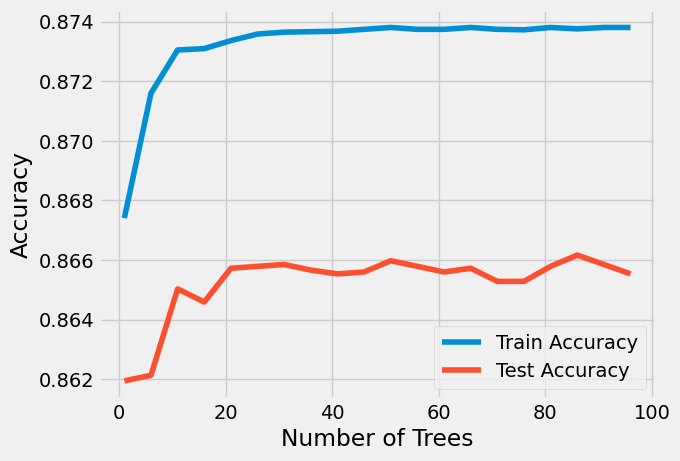

In [7]:
rf = train_data_func("train_data_all.csv")

hacker 0: 1282 , hacker 1: 1491 , hacker 2: 2252
Accuracy: 0.5508457711442786
Micro F1-Score: 0.5512297122373794
Macro F1-Score: 0.5084776570524531
Weighted F1-Score: 0.43098691012367546
AUC: 0.7322100185021503
混淆矩陣:


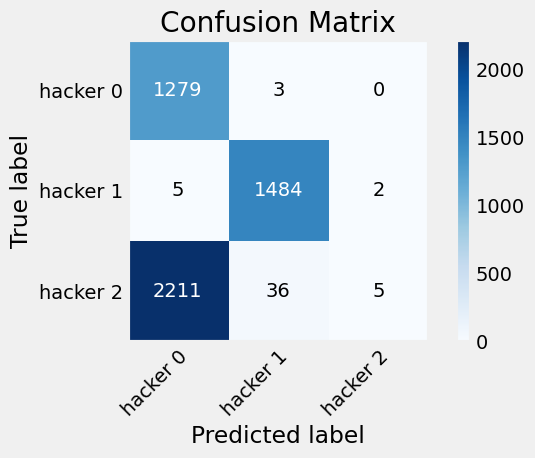

In [8]:
vail_data(rf, "test_data_all.csv")